In [1]:
# default_exp doublediff_analysis

In [2]:
%reload_ext autoreload
%autoreload 2

## Unit Tests

In [11]:
#hide
import uuid
import alphaquant.diffquant.background_distributions as aqbg
import alphaquant.benchm.benchmarking as aqbm
import alphaquant.diffquant.doublediff_analysis as aqdd
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def test_doublediff(num_ionsets = 10, fixed_size = None, simulate_nas = True):

    sample2cond_df = generate_sample2cond_df(3, 3)
    unnormed_df = aqbm.generate_random_input(1000, sample2cond_df,simulate_nas, systematic_offset=1)
    df_c1, df_c2 = get_c1_c2_dfs(unnormed_df, sample2cond_df, ["A", "B"])
    p2z = {}
    normed_c1 = aqbg.ConditionBackgrounds(df_c1, p2z)
    normed_c2 = aqbg.ConditionBackgrounds(df_c2, p2z)
    pvals = test_calc_doublediff_score(normed_c1, normed_c2, num_ionsets, fixed_size)
    return pvals

def generate_sample2cond_df(reps_sample1, reps_sample2):
    return pd.DataFrame({
        'sample' : [f'A{i}' for i in range(reps_sample1)] +[f'B{i}' for i in range(reps_sample2)],
        'condition' : ['A']*reps_sample1 + ['B']*reps_sample2})


def test_calc_doublediff_score(normed_c1, normed_c2, num_ionsets, fixed_size = None):
    pvals = []
    fcfcs = []
    allions = list(set(normed_c1.ion2background.keys()).intersection(set(normed_c2.ion2background.keys())))
    allions = np.array(allions)
    if fixed_size is not None:
        ionsets = [allions[np.random.randint(len(allions), size=fixed_size)] for _ in range(num_ionsets)]
    else:
        ionsets = [allions[np.random.randint(len(allions), size=np.random.randint(1,10))] for _ in range(num_ionsets)]

    count_iters = 0
    ion2diffDist={}
    p2z ={} 
    deedpair2doublediffdist = {}

    ions1 = ionsets[0]

    for ions2 in ionsets[1:]:
        systematic_offset = 0
        #add_systematic_offset_to_ions(ions2, normed_c2, systematic_offset=systematic_offset)
        fcfc, p = aqdd.calc_doublediff_score(ions1, ions2, normed_c1, normed_c2, ion2diffDist,p2z, deedpair2doublediffdist)
        #add_systematic_offset_to_ions(ions2, normed_c2, systematic_offset=-systematic_offset)
        pvals.append(p)
        fcfcs.append(fcfc)

        if p < 1e-2:
            print(f"pval: {p}")
            for ion1 in ions1:
                print(f"ion1: {normed_c1.ion2allvals[ion1]}")
            for ion2 in ions2:
                print(f"ion2: {normed_c2.ion2allvals[ion2]}")
    
    return pvals, fcfcs


def add_systematic_offset_to_ions(ions, normed_c2, systematic_offset):
    for ion in ions:
        print(normed_c2.ion2allvals[ion])
        normed_c2.ion2allvals[ion] = normed_c2.ion2allvals.get(ion) + systematic_offset
        print(normed_c2.ion2allvals[ion])


def get_c1_c2_dfs(unnormed_df, labelmap_df, condpair, minrep = 2):
    c1_samples = labelmap_df[labelmap_df["condition"]== condpair[0]]
    c2_samples = labelmap_df[labelmap_df["condition"]== condpair[1]]
    df_c1 = unnormed_df.loc[:, c1_samples["sample"]].dropna(thresh=minrep, axis=0)
    df_c2 = unnormed_df.loc[:, c2_samples["sample"]].dropna(thresh=minrep, axis=0)

    return df_c1, df_c2


pvals_differentsizes, fcfcs_differentsizes = test_doublediff(num_ionsets=500)
pvals_fixedsize, fcfcs_fixedsize = test_doublediff(500, fixed_size = 4, simulate_nas=False)



t_ion2nonan_sw 0.0009598731994628906
t_intensity_selection 0.027847766876220703
t_ion2nonan_sw 0.0009529590606689453
t_intensity_selection 0.05416703224182129
pval: 0.003670341499028673
ion1: [ 9.35907156  8.91881437 10.72583848]
ion1: [11.59534858 13.36919345  9.54545254]
ion1: [10.57338241  8.79403439 13.36170185]
ion2: [ 2.48038265  5.71419414 10.61143394]
pval: 0.0005855149298965578
ion1: [ 9.35907156  8.91881437 10.72583848]
ion1: [11.59534858 13.36919345  9.54545254]
ion1: [10.57338241  8.79403439 13.36170185]
ion2: [2.81785808 6.21643893 7.62782862]
pval: 0.0023857144561487686
ion1: [ 9.35907156  8.91881437 10.72583848]
ion1: [11.59534858 13.36919345  9.54545254]
ion1: [10.57338241  8.79403439 13.36170185]
ion2: [11.62506681  5.9793713   7.29933514]
ion2: [8.97384639 6.47163209 6.68057603]
t_ion2nonan_sw 0.0009341239929199219
t_intensity_selection 0.026690006256103516
t_ion2nonan_sw 0.0009009838104248047
t_intensity_selection 0.04844808578491211


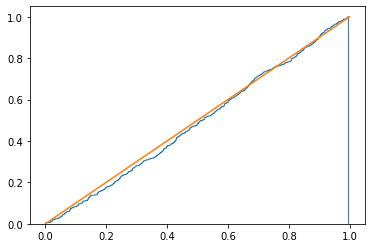

0.18264879417232424


<AxesSubplot:>

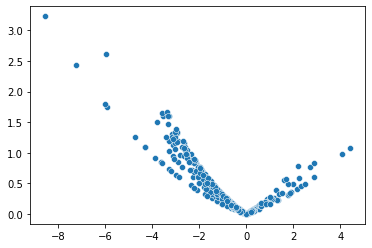

In [12]:
#hide
import alphaquant.viz.visualizations as aqviz
import scipy.stats as stats
import seaborn as sns

plt.hist(pvals_differentsizes, cumulative=True, bins = 1000, histtype = "step", density = True)
x = np.linspace(0,1,100)
plt.plot(x, x)
plt.show()
np.random.seed(42)
unidist = np.random.uniform(size=1000)

pval = stats.ks_2samp(pvals_differentsizes, unidist)[1]
print(pval)
#assert pval > 0.1
sns.scatterplot(x = fcfcs_differentsizes,y = -np.log10(pvals_differentsizes))



In [5]:
import random
def plot_dependence_of_pval_on_ion_shift_and_number(normed_c1, normed_c2, ion2diffDist,p2z, deedpair2doublediffdist):
    ions1 = sample_ions(ion2diffDist, 4)
    ions2 = sample_ions(ion2diffDist, 4)

    
    pass

def sample_ions(ion2diffdist, num_ions):
    return random.sample(list(ion2diffdist.keys()), num_ions)
    


SyntaxError: invalid syntax (3891463511.py, line 1)